<a href="https://colab.research.google.com/github/dataByCarl/2022_datathon/blob/main/ElderNet_Pantry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
pantry=pd.read_csv('/content/gdrive/MyDrive/dataPhilly_ElderNet/pantry.csv')

**Pantry Info**

    1. Look at nulls/NAs
    2. Transpose donations to one column per type (e.g. pantry_pounds,holiday_pounds,easter_pounds,pantry_dollars,holiday_dollars,easter_dollars)
    3. Transpose assistance_dates to first/last/count/duration, i.e. convert assistance_date to first_assistance, last_assistance, assistance_count, assistance_duration
       a) drop original assistance
       b) drop duplicate rows based on anon_ID



In [4]:
pantry.head(3)


,anon_ID,assistance_date,assistance_category,amount,unit
0,102,1/3/2019 10:00,Food Pantry: Food Pantry Poundage,25,Pounds
1,178,1/3/2019 10:00,Food Pantry: Food Pantry Poundage,25,Pounds
2,588,1/3/2019 10:30,Food Pantry: Food Pantry Poundage,25,Pounds


In [6]:
pantry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6273 entries, 0 to 6272
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   anon_ID              6273 non-null   int64 
 1   assistance_date      6273 non-null   object
 2   assistance_category  6273 non-null   object
 3   amount               6273 non-null   int64 
 4   unit                 6273 non-null   object
dtypes: int64(2), object(3)
memory usage: 245.2+ KB


In [5]:
# Check for missing values
pantry.isnull().sum()

anon_ID                0
assistance_date        0
assistance_category    0
amount                 0
unit                   0
dtype: int64

In [7]:
# identify categories
pantry['assistance_category'].unique()

array(['Food Pantry: Food Pantry Poundage',
       'Food Pantry: Easter Outreach', 'Food Pantry: Holiday Baskets'],
      dtype=object)

In [8]:
pantry['unit'].unique()

array(['Pounds', 'Boxes/Bags', 'Dollars'], dtype=object)

Get Counts of Assistance

In [9]:
# Append countOfAssists
countOfAssists=pantry.groupby(['anon_ID'])['assistance_date'].count()
countOfAssists_df=pd.DataFrame(countOfAssists)
countOfAssists_df.rename(columns={'assistance_date':'countPantryAssists'},inplace=True)
pantry=pd.merge(pantry,countOfAssists_df, on=['anon_ID'])

Identify First and Last Dates of Pantry Assistance.
<p>Calculate Duration (LastDate-FirstDate)

In [10]:
# convert assistance_date "object" to "date" format
pantry['assistance_date']=pd.to_datetime(pantry['assistance_date']).dt.date

# *** Double Check min/max; This doesn't seem 100% correct ***
# Append a column 'first_assist' based on minimum date per anon_ID
first_assist=pantry.groupby(['anon_ID'])['assistance_date'].min()
cm_min_df=pd.DataFrame(first_assist)
cm_min_df.rename(columns={'assistance_date':'pantry_first_assist'},inplace=True)
pantry=pd.merge(pantry,cm_min_df, on=['anon_ID'])

# Append a column 'last_assist' based on maximum date per anon_ID
last_assist=pantry.groupby(['anon_ID'])['assistance_date'].max()
cm_max_df=pd.DataFrame(last_assist)
cm_max_df.rename(columns={'assistance_date':'pantry_last_assist'},inplace=True)
pantry=pd.merge(pantry,cm_max_df, on=['anon_ID'])

# Convert date fields from objects to dates so can calculate
pantry['pantry_first_assist']=pd.to_datetime(pantry['pantry_first_assist'])
pantry['pantry_last_assist']=pd.to_datetime(pantry['pantry_last_assist'])
# durationOfAssist = lastAssist - firstAssist
pantry['pantry_duration'] =pantry['pantry_last_assist']-pantry['pantry_first_assist']

In [26]:
pantry.tail()

,anon_ID,countPantryAssists,pantry_first_assist,pantry_last_assist,pantry_duration,sumPantryPounds,sumPantryDollars,sumEasterPounds,sumEasterBags,sumHolidayPounds,sumHolidayDollars
6262,397,3,2021-08-03,2021-09-02,30 days,75,0,0,0,0,0
6265,269,3,2021-08-03,2021-08-31,28 days,75,0,0,0,0,0
6268,497,3,2021-08-03,2021-09-02,30 days,75,0,0,0,0,0
6271,398,1,2021-08-05,2021-08-05,0 days,25,0,0,0,0,0
6272,528,1,2021-08-26,2021-08-26,0 days,25,0,0,0,0,0


Iterate over each row
<p>If assistance_category "Food Pantry: Food Pantry Poundage" && Pounds, then populate column pantry_pounds
repeat for each category type and unit combination
<p>Goal:  convert to columns with uniform units
<p><p>  Then will sum each new column per AnonID and give count per AnonID 


In [12]:
pantryPounds_L=[]
pantryDollars_L=[]
easterPounds_L=[]
easterBags_L=[]
holidayPounds_L=[]
holidayDollars_L=[]
# Loop through all rows in dataframe.  Depending on combination of category and unit, store amount in new column
# eg Food Pantry Poundage AND Pounds --> pantry_pounds
#    Food Pantry Poundage AND dollars -> pantry_dollars
for ind in pantry.index:
	# category=Food Pantry: Food Pantry Poundage
	if (pantry['assistance_category'][ind]=='Food Pantry: Food Pantry Poundage') and (pantry['unit'][ind]=='Pounds'):
		pantryPounds_L.append(pantry['amount'][ind])
		pantryDollars_L.append('0')
		easterPounds_L.append('0')
		easterBags_L.append('0')
		holidayPounds_L.append('0')
		holidayDollars_L.append('0')
	elif (pantry['assistance_category'][ind]=='Food Pantry: Food Pantry Poundage') and (pantry['unit'][ind]=='Dollars'):
		pantryPounds_L.append('0')
		pantryDollars_L.append(pantry['amount'][ind])
		easterPounds_L.append('0')
		easterBags_L.append('0')
		holidayPounds_L.append('0')
		holidayDollars_L.append('0')
	elif (pantry['assistance_category'][ind]=='Food Pantry: Easter Outreach') and (pantry['unit'][ind]=='Pounds'):
		pantryPounds_L.append('0')
		pantryDollars_L.append(0)
		easterPounds_L.append(pantry['amount'][ind])
		easterBags_L.append('0')
		holidayPounds_L.append('0')
		holidayDollars_L.append('0')
	elif (pantry['assistance_category'][ind]=='Food Pantry: Easter Outreach') and (pantry['unit'][ind]=='Boxes/Bags'):
		pantryPounds_L.append('0')
		pantryDollars_L.append(0)
		easterPounds_L.append('0')
		easterBags_L.append(pantry['amount'][ind])
		holidayPounds_L.append('0')
		holidayDollars_L.append('0')
	elif (pantry['assistance_category'][ind]=='Food Pantry: Holiday Baskets') and (pantry['unit'][ind]=='Pounds'):
		pantryPounds_L.append('0')
		pantryDollars_L.append(0)
		easterPounds_L.append('0')
		easterBags_L.append('0')
		holidayPounds_L.append(pantry['amount'][ind])
		holidayDollars_L.append('0')
	elif(pantry['assistance_category'][ind]=='Food Pantry: Holiday Baskets') and (pantry['unit'][ind]=='Dollars'):
		pantryPounds_L.append('0')
		pantryDollars_L.append('0')
		easterPounds_L.append('0')
		easterBags_L.append('0')
		holidayPounds_L.append('0')
		holidayDollars_L.append(pantry['amount'][ind])
	else:
		pantryPounds_L.append('0')
		pantryDollars_L.append('0')
		easterPounds_L.append('0')
		easterBags_L.append('0')
		holidayPounds_L.append('0')
		holidayDollars_L.append('0')

# Append new category/unit columns
pantry['pantry_pounds']=pd.DataFrame(pantryPounds_L).astype(int)
pantry['pantry_dollars']=pd.DataFrame(pantryDollars_L).astype(int)
pantry['easter_pounds']=pd.DataFrame(easterPounds_L).astype(int)
pantry['easter_bags']=pd.DataFrame(easterBags_L).astype(int)
pantry['holiday_pounds']=pd.DataFrame(holidayPounds_L).astype(int)
pantry['holiday_dollars']=pd.DataFrame(holidayDollars_L).astype(int)

In [27]:
pantry.head()

,anon_ID,countPantryAssists,pantry_first_assist,pantry_last_assist,pantry_duration,sumPantryPounds,sumPantryDollars,sumEasterPounds,sumEasterBags,sumHolidayPounds,sumHolidayDollars
0,102,64,2019-01-03,2021-08-26,966 days,1575,0,0,0,30,0
64,178,68,2019-01-03,2021-09-07,978 days,1625,0,0,0,90,0
132,588,65,2019-01-03,2021-09-02,973 days,1500,0,0,0,90,100
197,502,55,2019-01-03,2021-08-24,964 days,1300,0,0,0,30,50
252,232,27,2019-01-03,2021-04-06,824 days,650,0,0,0,30,0


In [14]:
# Calculate sum by each new column (pantry_pounds, pantry_dollars, etc.)
# pantry pounds
#  Create a list of sums by ID
#  Create temporary dataframe with that list
#  Rename the new column to reflect it is a sum
#  Merge that dataframe with the main one
mySums=pantry.groupby(['anon_ID'])['pantry_pounds'].sum()
mySums_df=pd.DataFrame(mySums)
mySums_df.rename(columns={'pantry_pounds':'sumPantryPounds'},inplace=True)
pantry=pd.merge(pantry,mySums_df, on=['anon_ID'])

# pantry dollars
pantry['pantry_dollars'].astype(str) # can only build list of strings?
mySums=pantry.groupby(['anon_ID'])['pantry_dollars'].sum()
mySums_df=pd.DataFrame(mySums)
mySums_df.rename(columns={'pantry_dollars':'sumPantryDollars'},inplace=True)
pantry=pd.merge(pantry,mySums_df, on=['anon_ID'])

# easter pounds
mySums=pantry.groupby(['anon_ID'])['easter_pounds'].sum()
mySums_df=pd.DataFrame(mySums)
mySums_df.rename(columns={'easter_pounds':'sumEasterPounds'},inplace=True)
pantry=pd.merge(pantry,mySums_df, on=['anon_ID'])

# easter bags
mySums=pantry.groupby(['anon_ID'])['easter_bags'].sum()
mySums_df=pd.DataFrame(mySums)
mySums_df.rename(columns={'easter_bags':'sumEasterBags'},inplace=True)
pantry=pd.merge(pantry,mySums_df, on=['anon_ID'])

# holiday pounds
mySums=pantry.groupby(['anon_ID'])['holiday_pounds'].sum()
mySums_df=pd.DataFrame(mySums)
mySums_df.rename(columns={'holiday_pounds':'sumHolidayPounds'},inplace=True)
pantry=pd.merge(pantry,mySums_df, on=['anon_ID'])

# holiday dollars
mySums=pantry.groupby(['anon_ID'])['holiday_dollars'].sum()
mySums_df=pd.DataFrame(mySums)
mySums_df.rename(columns={'holiday_dollars':'sumHolidayDollars'},inplace=True)
pantry=pd.merge(pantry,mySums_df, on=['anon_ID'])


In [15]:
# Calculate sums per anon_ID
pantry.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6273 entries, 0 to 6272
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   anon_ID              6273 non-null   int64          
 1   assistance_date      6273 non-null   object         
 2   assistance_category  6273 non-null   object         
 3   amount               6273 non-null   int64          
 4   unit                 6273 non-null   object         
 5   countPantryAssists   6273 non-null   int64          
 6   pantry_first_assist  6273 non-null   datetime64[ns] 
 7   pantry_last_assist   6273 non-null   datetime64[ns] 
 8   pantry_duration      6273 non-null   timedelta64[ns]
 9   pantry_pounds        6273 non-null   int64          
 10  pantry_dollars       6273 non-null   int64          
 11  easter_pounds        6273 non-null   int64          
 12  easter_bags          6273 non-null   int64          
 13  holiday_pounds    

In [16]:
# Drop duplicate rows
pantry.drop_duplicates(subset='anon_ID',inplace=True)

In [17]:
# Drop columns: assistance_date, assistance_category, amount, unit
pantry=pantry.drop('assistance_date',axis=1)
pantry=pantry.drop('assistance_category',axis=1)
pantry=pantry.drop('amount',axis=1)
pantry=pantry.drop('unit',axis=1)

# Now that summed up, no longer need Pantry_Pounds & Dollars/EasterPounds&Dollars/HolidayPounds&Dollars
pantry=pantry.drop('pantry_pounds',axis=1)
pantry=pantry.drop('pantry_dollars',axis=1)
pantry=pantry.drop('easter_pounds',axis=1)
pantry=pantry.drop('easter_bags',axis=1)
pantry=pantry.drop('holiday_pounds',axis=1)
pantry=pantry.drop('holiday_dollars',axis=1)



In [18]:
pantry.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
anon_ID,414.0,319.297101,187.389783,2.0,152.25,315.5,483.5,639.0
countPantryAssists,414.0,15.152174,18.499356,1.0,2.0,7.0,23.0,98.0
pantry_duration,414,373 days 13:02:36.521739132,342 days 23:18:25.864954012,0 days 00:00:00,29 days 06:00:00,332 days 12:00:00,657 days 18:00:00,978 days 00:00:00
sumPantryPounds,414.0,350.966184,442.795061,0.0,25.0,150.0,543.75,2350.0
sumPantryDollars,414.0,0.169082,1.466465,0.0,0.0,0.0,0.0,20.0
sumEasterPounds,414.0,0.144928,1.196549,0.0,0.0,0.0,0.0,10.0
sumEasterBags,414.0,0.118357,1.301145,0.0,0.0,0.0,0.0,24.0
sumHolidayPounds,414.0,24.746377,33.534644,0.0,0.0,0.0,30.0,180.0
sumHolidayDollars,414.0,7.18599,17.659455,0.0,0.0,0.0,0.0,125.0


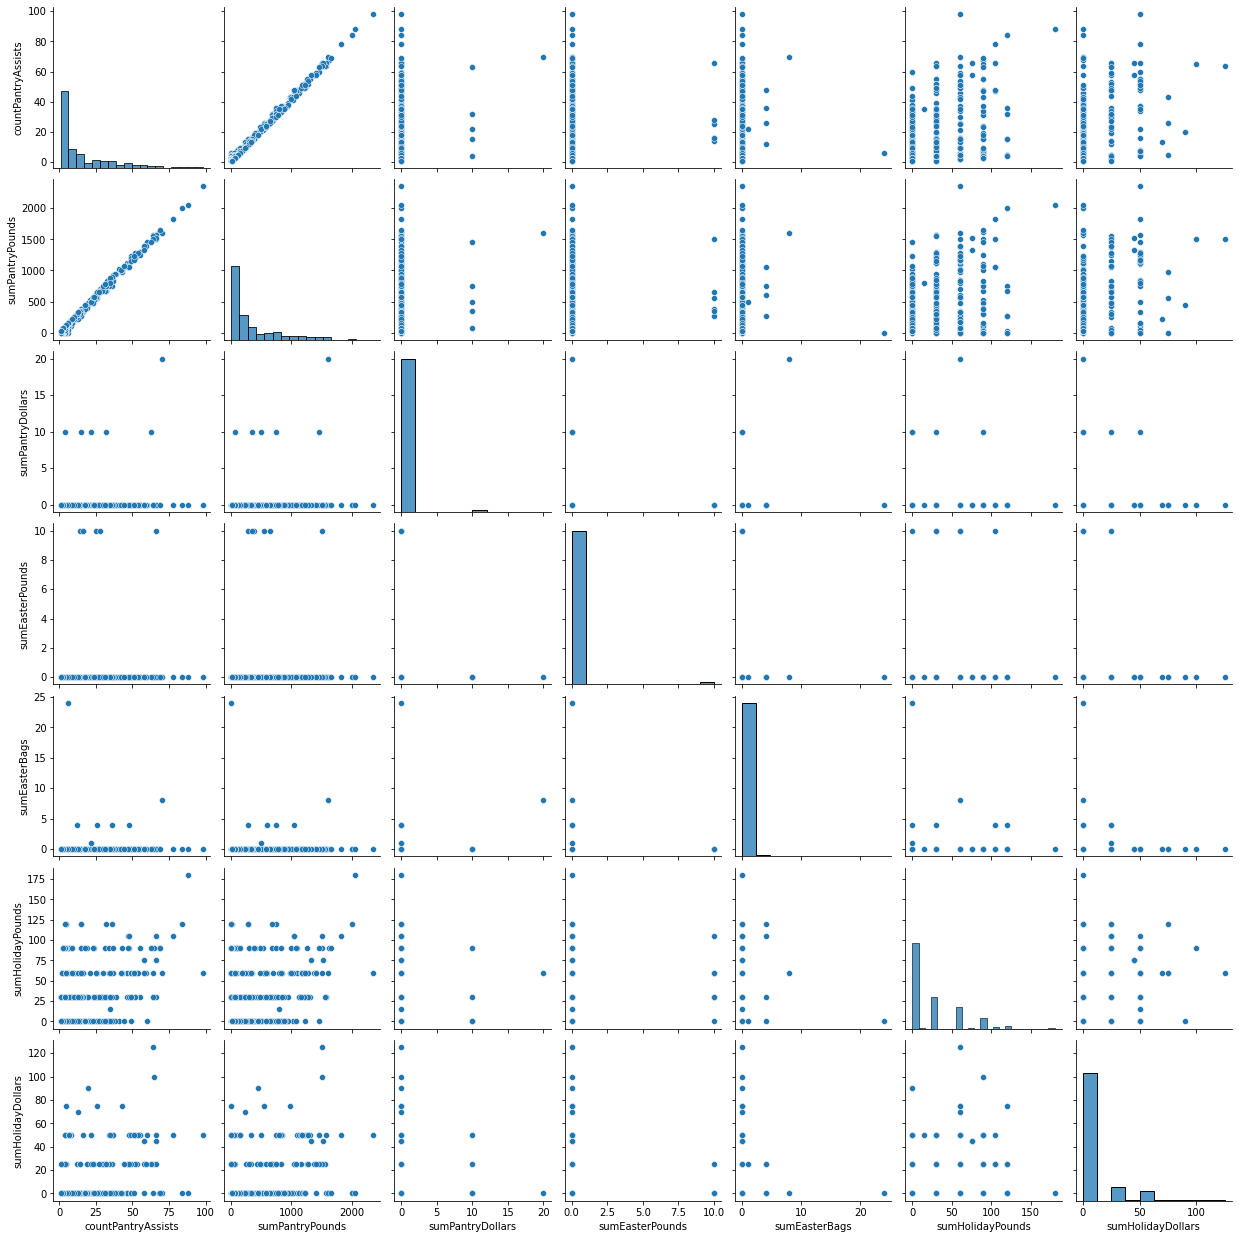

In [19]:
pantryNoID_DF=pantry[['countPantryAssists','pantry_first_assist','pantry_last_assist','pantry_duration',
                    'sumPantryPounds','sumPantryDollars',
                    'sumEasterPounds','sumEasterBags','sumHolidayPounds','sumHolidayDollars']]
sns.pairplot(pantryNoID_DF)

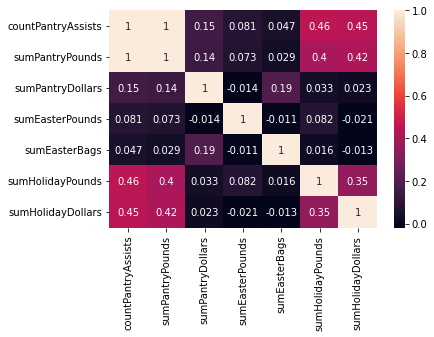

In [ ]:
sns.heatmap(pantryNoID_DF.corr(),annot=True)

In [29]:
pantry.to_csv('/content/gdrive/MyDrive/dataPhilly_ElderNet/pantry_flat.csv')